# This is the final set of sweep parameters using Weights & Biases (WandB). Parameters with minimal impact or infrequent use were removed based on results from previous sweeps.

In [ ]:
import wandb

wandb.login()

In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from glob import glob


def train():
    wandb.init()
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)



    train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
    val_dataset = CustomDataset(X_val, y_val, transform=val_transform)

    # train_dataset = CustomDataset(X_train, y_train)
    # val_dataset = CustomDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, pin_memory=True)


    model = smp.Unet(
        encoder_name=config.encoder_name,
        encoder_weights=config.encoder_weights,
        in_channels=3,
        classes=1
    ).to(device)


    if config.optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)


    criterion = smp.losses.DiceLoss(mode="binary")

    for epoch in range(11):
        model.train()
        total_loss = 0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0


        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                outputs = torch.sigmoid(outputs)

                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "val_loss": avg_val_loss,
        })


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'dice_loss', 'goal': 'minimize'},
    'parameters': {
        # 'epochs' : {'min':10, 'max': 30},
        'learning_rate': {'min': 0.00009, 'max': 0.001,},
        'batch_size': {'values': [4, 8, 16]},
        'optimizer': {'values': ["Adam", "AdamW"]},
        'encoder_name': {'values': ["efficientnet-b4", "resnet18"]},
        'encoder_weights': {'values': ["imagenet"]},
        # 'loss_function': "DiceLoss",
        # 'threshold': {'min': 0.3, 'max': 0.7},
        'model_architecture': {'values': ["Unet"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="colon-polyp-segmentation-3")
wandb.agent(sweep_id, function=train,count = 5)


# GRAPHS : TRAINING VS LOSS & VALIDATING VS LOSS

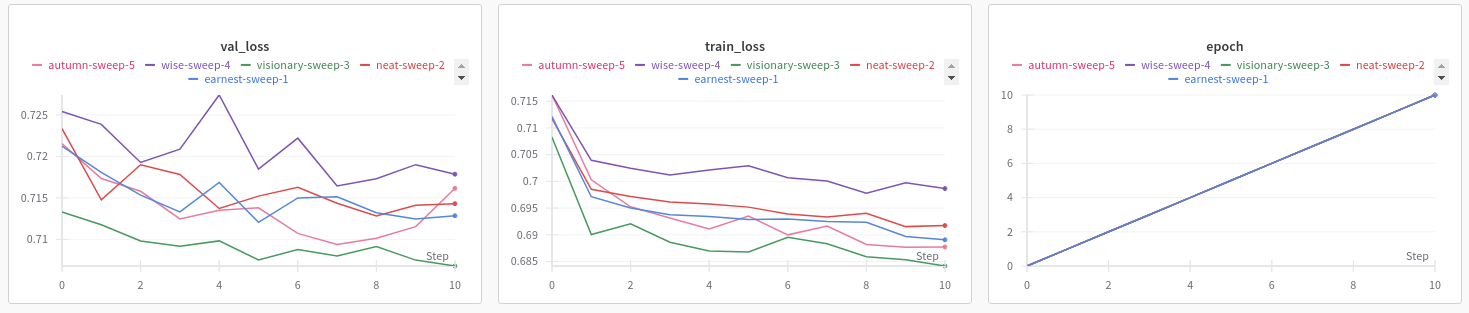

In [2]:
from IPython.display import Image
Image("WANDB_graph.png")


# TABLE : PARAMETERS AND SWEEPS

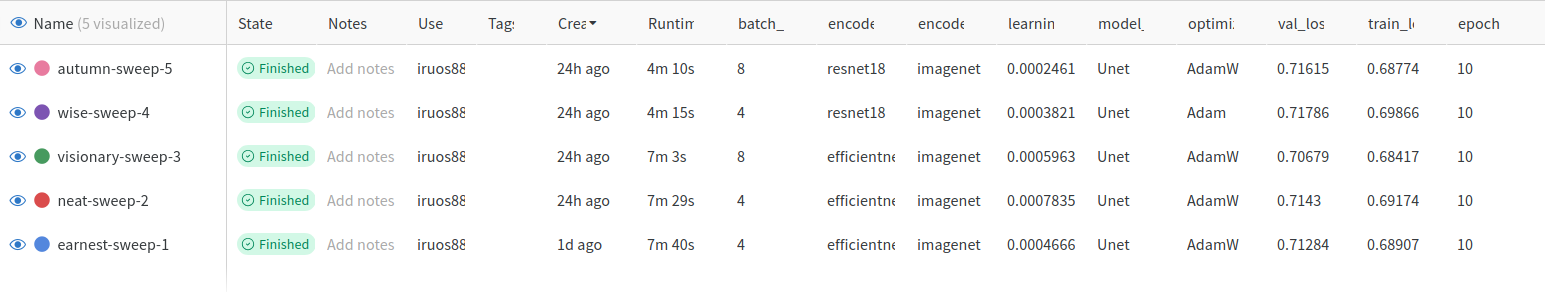

In [3]:
from IPython.display import Image
Image("WANDB_table.png")
